<a href="https://colab.research.google.com/github/altamashsameer/Computer_vision_BSBI/blob/main/plant_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:

import os
import glob
import zipfile
import time
import tensorflow as tf
from google.colab import drive


print("--- Mounting Google Drive ---")
drive.mount('/content/drive')

DRIVE_ZIP_PATH = '/content/drive/MyDrive/colab/new-plant-diseases.zip'
TARGET_UNZIP_DIR = '/content/dataset'


if not os.path.exists(TARGET_UNZIP_DIR):
    os.makedirs(TARGET_UNZIP_DIR, exist_ok=True)
    print(f"Unzipping dataset from {DRIVE_ZIP_PATH} ...")
    start_time = time.time()
    with zipfile.ZipFile(DRIVE_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(TARGET_UNZIP_DIR)
    end_time = time.time()
    print(f"Dataset unzipped in {end_time - start_time:.2f} seconds.")
else:
    print("Dataset already unzipped.")


BASE_DIR = os.path.join(TARGET_UNZIP_DIR, 'New Plant Diseases Dataset(Augmented)',
                        'New Plant Diseases Dataset(Augmented)')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')

print(f"Training directory: {TRAIN_DIR}")
print(f"Validation directory: {VALID_DIR}")


num_train_images = len(glob.glob(os.path.join(TRAIN_DIR, '*/*.jpg')))
num_valid_images = len(glob.glob(os.path.join(VALID_DIR, '*/*.jpg')))
num_classes = len(os.listdir(TRAIN_DIR))

print(f"Number of classes: {num_classes}")
print(f"Training images: {num_train_images}")
print(f"Validation images: {num_valid_images}")


--- Mounting Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already unzipped.
Training directory: /content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
Validation directory: /content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
Number of classes: 38
Training images: 2447
Validation images: 599


In [12]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [13]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')


base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]


In [15]:

EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.3546 - loss: 2.4961

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 953s 425ms/step - accuracy: 0.3547 - loss: 2.4958 - val_accuracy: 0.8124 - val_loss: 0.7567 - learning_rate: 1.0000e-04
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7851 - loss: 0.7888

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 869s 395ms/step - accuracy: 0.7851 - loss: 0.7888 - val_accuracy: 0.8589 - val_loss: 0.5139 - learning_rate: 1.0000e-04
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8356 - loss: 0.5743

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 858s 390ms/step - accuracy: 0.8356 - loss: 0.5743 - val_accuracy: 0.8827 - val_loss: 0.4182 - learning_rate: 1.0000e-04
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8605 - loss: 0.4760

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 870s 394ms/step - accuracy: 0.8605 - loss: 0.4760 - val_accuracy: 0.8947 - val_loss: 0.3688 - learning_rate: 1.0000e-04
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8756 - loss: 0.4196

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 861s 392ms/step - accuracy: 0.8756 - loss: 0.4196 - val_accuracy: 0.9010 - val_loss: 0.3361 - learning_rate: 1.0000e-04
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8809 - loss: 0.3910

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 873s 397ms/step - accuracy: 0.8809 - loss: 0.3910 - val_accuracy: 0.9089 - val_loss: 0.3106 - learning_rate: 1.0000e-04
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8900 - loss: 0.3641

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 848s 386ms/step - accuracy: 0.8900 - loss: 0.3641 - val_accuracy: 0.9112 - val_loss: 0.2993 - learning_rate: 1.0000e-04
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8939 - loss: 0.3455

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 848s 386ms/step - accuracy: 0.8939 - loss: 0.3455 - val_accuracy: 0.9191 - val_loss: 0.2755 - learning_rate: 1.0000e-04
Epoch 9/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8939 - loss: 0.3360

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 857s 390ms/step - accuracy: 0.8939 - loss: 0.3360 - val_accuracy: 0.9198 - val_loss: 0.2677 - learning_rate: 1.0000e-04
Epoch 10/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9019 - loss: 0.3180

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 858s 390ms/step - accuracy: 0.9019 - loss: 0.3180 - val_accuracy: 0.9226 - val_loss: 0.2586 - learning_rate: 1.0000e-04


MODEL EVALUATION

1. Plotting training history...


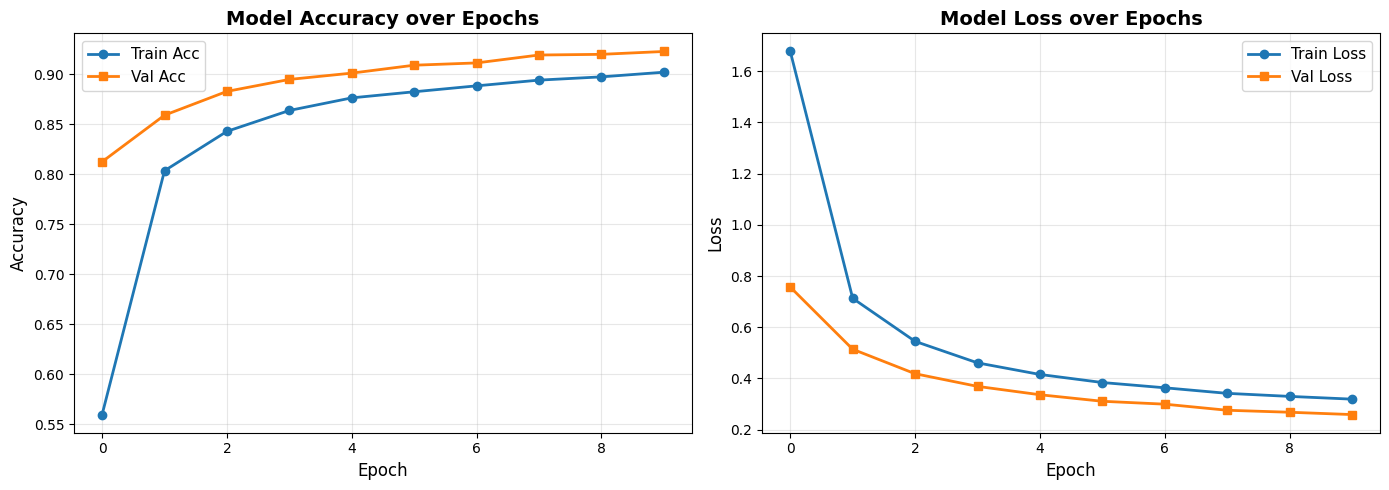


2. Generating predictions (this may take a moment)...
   Processed 100/550 batches...
   Processed 200/550 batches...
   Processed 300/550 batches...
   Processed 400/550 batches...
   Processed 500/550 batches...

✓ Generated 17572 predictions

OVERALL ACCURACY: 0.9226 (92.26%)

3. Computing confusion matrix...
   Confusion Matrix Shape: (38, 38)
   Correct predictions (diagonal sum): 16212
   Total predictions: 17572


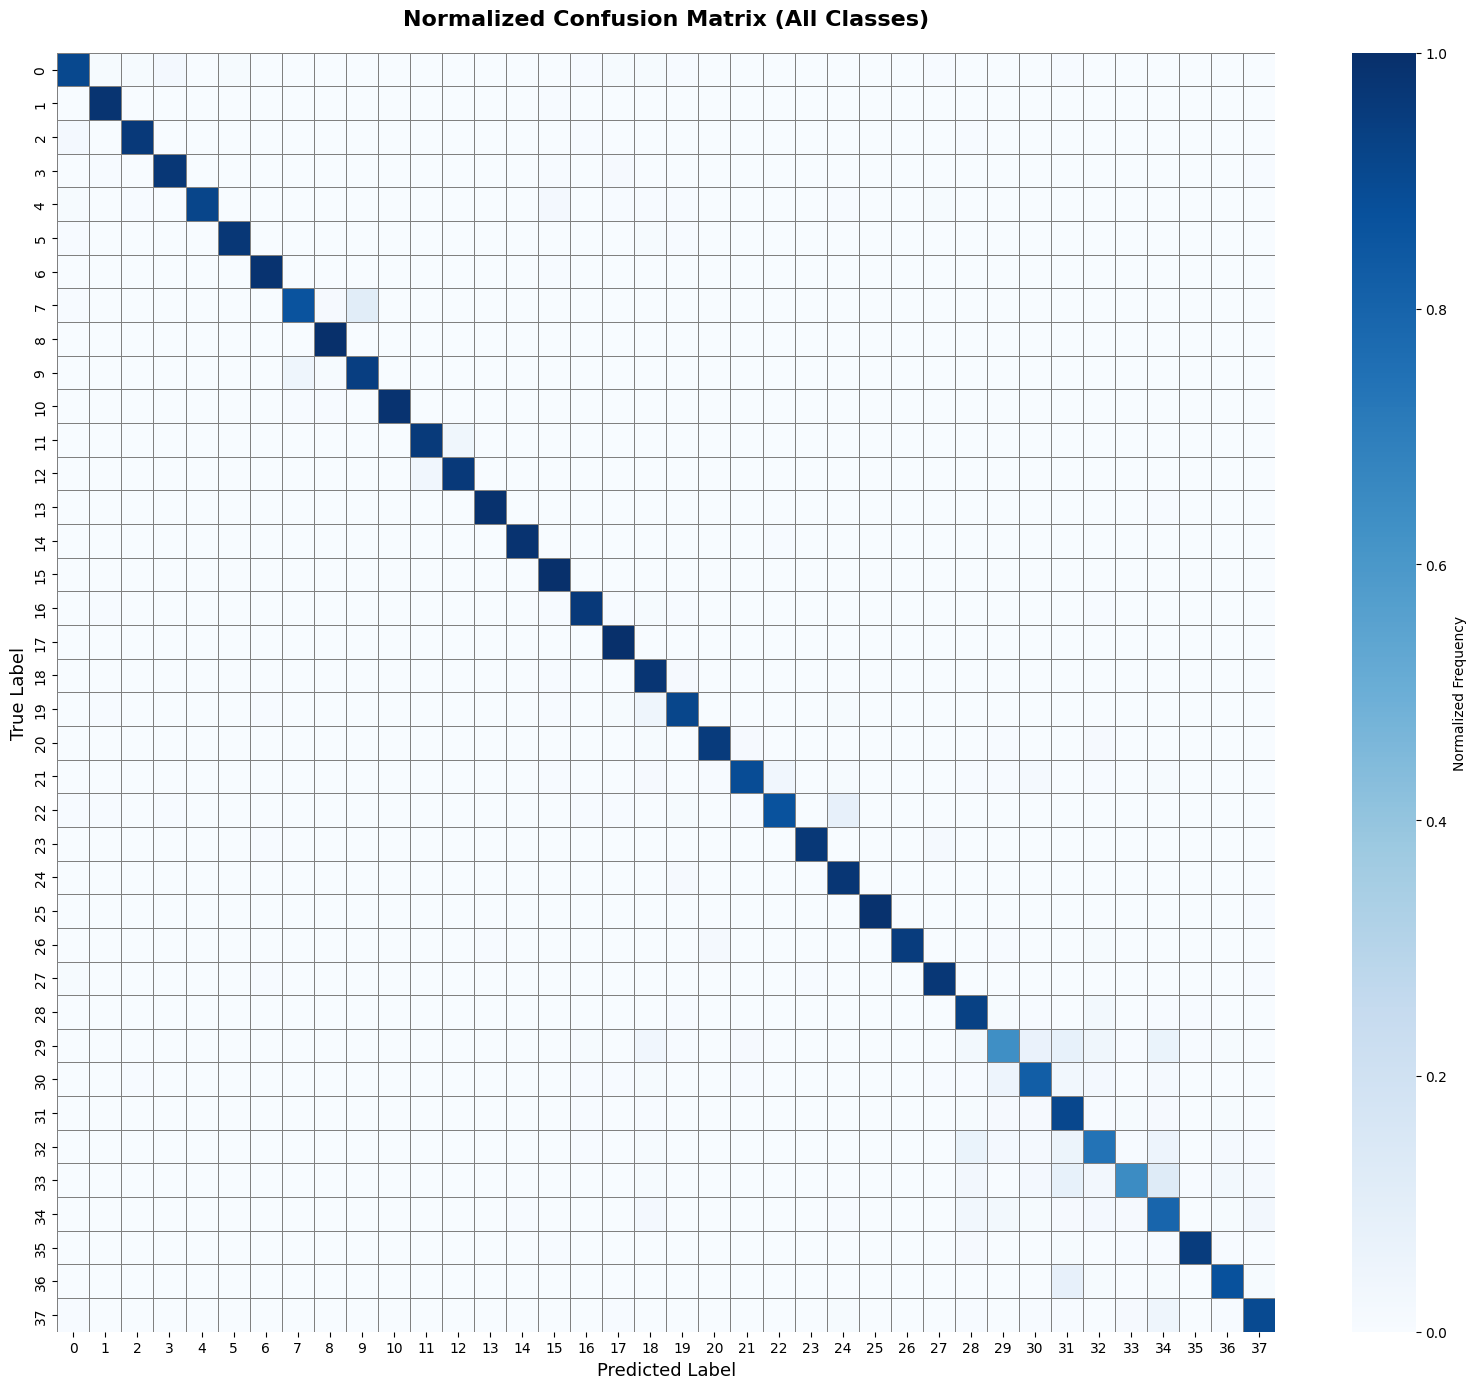


4. Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9328    0.9087    0.9206       504
                                 Apple___Black_rot     0.9626    0.9839    0.9731       497
                          Apple___Cedar_apple_rust     0.9724    0.9614    0.9669       440
                                   Apple___healthy     0.9644    0.9701    0.9672       502
                               Blueberry___healthy     0.9976    0.9207    0.9576       454
          Cherry_(including_sour)___Powdery_mildew     0.9903    0.9691    0.9796       421
                 Cherry_(including_sour)___healthy     0.9825    0.9868    0.9847       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9392    0.8659    0.9010       410
                       Corn_(maize)___Common_rust_     0.9714    0.9979    0.9845       477
               Corn_(maize)___Northern_Leaf_Blight  

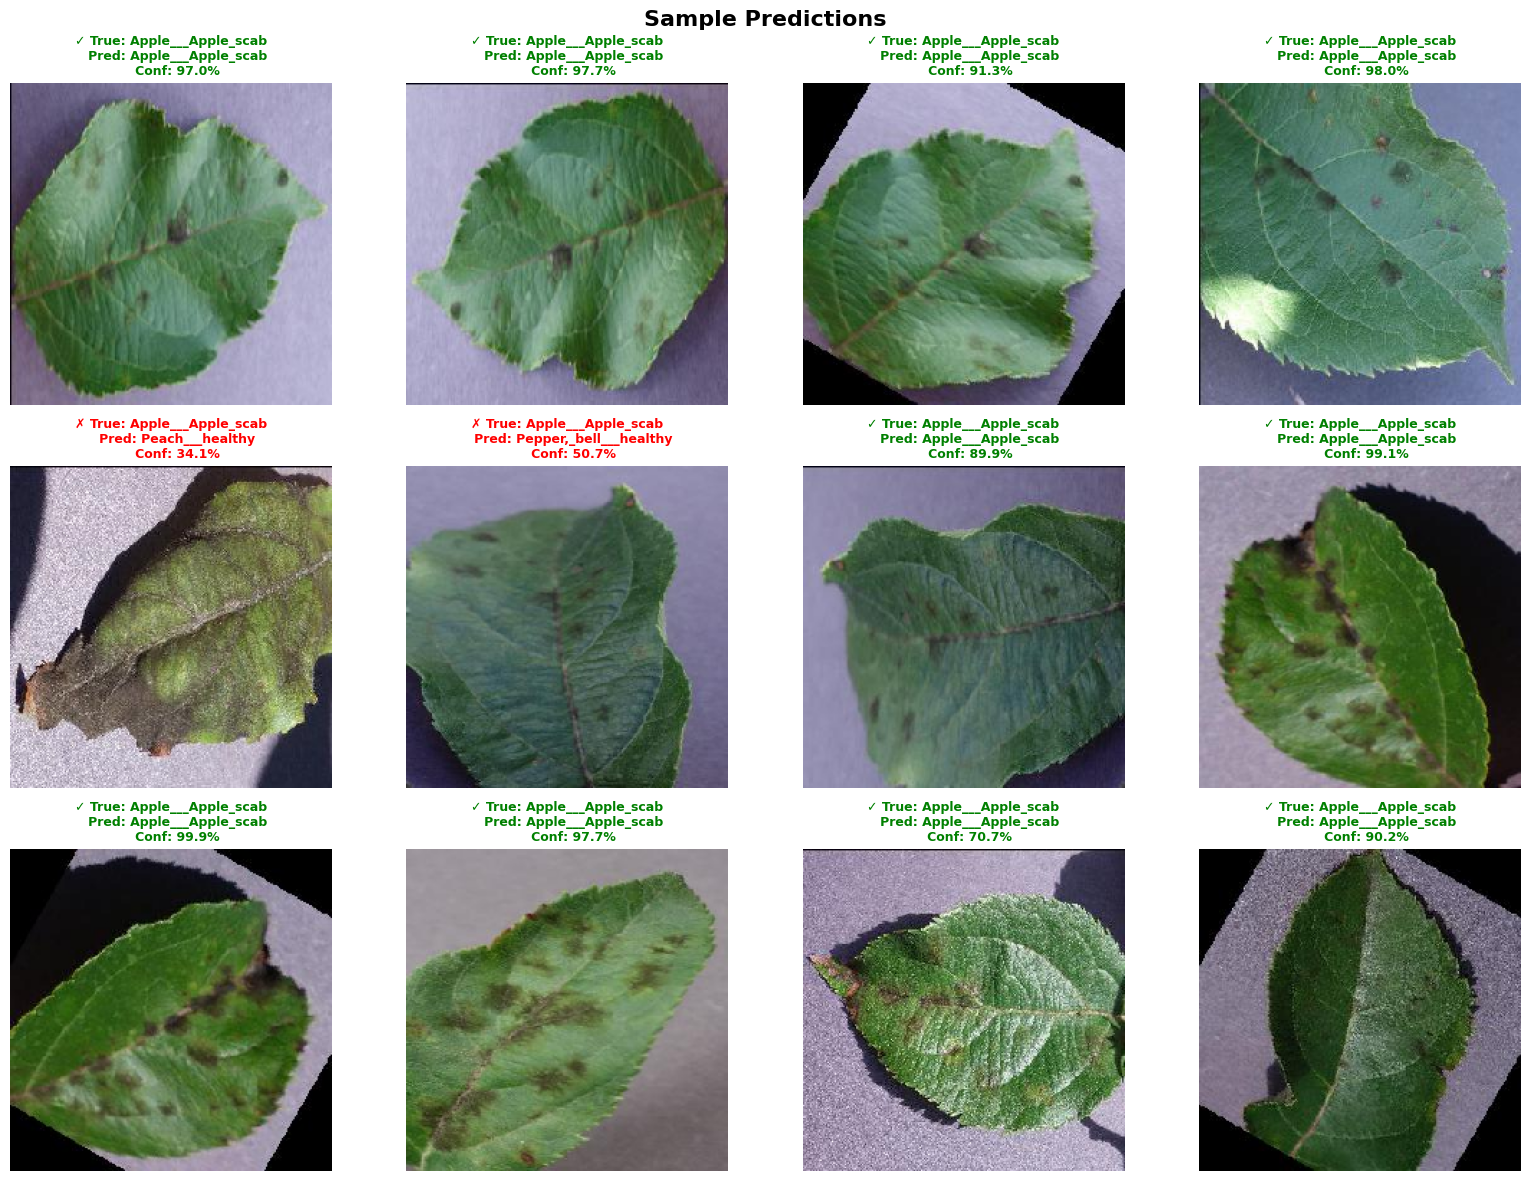


8. Summary Statistics:
Total validation samples:            17,572
Correctly classified:                16,212
Incorrectly classified:               1,360
Overall accuracy:                    92.26%
Average per-class accuracy:          92.20%
Best class accuracy:                100.00%
Worst class accuracy:                63.33%

✓ Model evaluation complete!


In [19]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("="*80)
print("MODEL EVALUATION")
print("="*80)


print("\n1. Plotting training history...")
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='s', linewidth=2)
plt.title('Model Accuracy over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', marker='s', linewidth=2)
plt.title('Model Loss over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("\n2. Generating predictions (this may take a moment)...")


valid_generator.reset()
valid_generator.shuffle = False

y_true_list = []
y_pred_list = []
batch_count = 0


for i in range(len(valid_generator)):
    x_batch, y_batch = valid_generator[i]


    pred_batch = model.predict(x_batch, verbose=0)


    true_classes = np.argmax(y_batch, axis=1)
    pred_classes = np.argmax(pred_batch, axis=1)


    y_true_list.extend(true_classes)
    y_pred_list.extend(pred_classes)

    batch_count += 1
    if batch_count % 100 == 0:
        print(f"   Processed {batch_count}/{len(valid_generator)} batches...")


y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

print(f"\n✓ Generated {len(y_true)} predictions")


overall_accuracy = np.mean(y_true == y_pred)
print(f"\n{'='*80}")
print(f"OVERALL ACCURACY: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"{'='*80}")

print("\n3. Computing confusion matrix...")
cm = confusion_matrix(y_true, y_pred)

print(f"   Confusion Matrix Shape: {cm.shape}")
print(f"   Correct predictions (diagonal sum): {cm.diagonal().sum()}")
print(f"   Total predictions: {cm.sum()}")


plt.figure(figsize=(16, 14))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues',
            cbar_kws={'label': 'Normalized Frequency'},
            linewidths=0.5, linecolor='gray')

plt.title('Normalized Confusion Matrix (All Classes)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.tight_layout()
plt.show()


print("\n4. Classification Report:")
print("="*80)

target_names = list(valid_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names,
                               digits=4, zero_division=0)
print(report)

from sklearn.metrics import precision_score, recall_score, f1_score

macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

weighted_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
weighted_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n5. Additional Metrics:")
print("="*80)
print(f"{'Metric':<25} {'Macro Avg':>12} {'Weighted Avg':>15}")
print("-"*80)
print(f"{'Precision':<25} {macro_precision:>12.4f} {weighted_precision:>15.4f}")
print(f"{'Recall':<25} {macro_recall:>12.4f} {weighted_recall:>15.4f}")
print(f"{'F1-Score':<25} {macro_f1:>12.4f} {weighted_f1:>15.4f}")
print("="*80)

print("\n6. Per-Class Performance Analysis:")
print("="*80)

per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
class_performance = list(zip(target_names, per_class_accuracy, cm.sum(axis=1)))
class_performance.sort(key=lambda x: x[1], reverse=True)

print("\nTOP 10 BEST PERFORMING CLASSES:")
print(f"{'Rank':<6} {'Class Name':<50} {'Accuracy':>10} {'Support':>10}")
print("-"*80)
for i, (name, acc, support) in enumerate(class_performance[:10], 1):
    print(f"{i:<6} {name:<50} {acc:>9.2%} {int(support):>10}")

print("\nTOP 10 WORST PERFORMING CLASSES:")
print(f"{'Rank':<6} {'Class Name':<50} {'Accuracy':>10} {'Support':>10}")
print("-"*80)
for i, (name, acc, support) in enumerate(class_performance[-10:][::-1], 1):
    print(f"{i:<6} {name:<50} {acc:>9.2%} {int(support):>10}")


print("\n7. Visualizing sample predictions...")

def visualize_predictions(num_samples=12):
    """Visualize sample predictions with images"""
    valid_generator.reset()
    x_batch, y_batch = next(valid_generator)

    pred_batch = model.predict(x_batch[:num_samples], verbose=0)
    pred_classes = np.argmax(pred_batch, axis=1)
    true_classes = np.argmax(y_batch[:num_samples], axis=1)

    class_names = list(valid_generator.class_indices.keys())

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for i in range(num_samples):
        ax = axes[i]
        img = x_batch[i]

        true_idx = true_classes[i]
        pred_idx = pred_classes[i]
        confidence = pred_batch[i][pred_idx] * 100

        true_name = class_names[true_idx]
        pred_name = class_names[pred_idx]


        ax.imshow(img)
        ax.axis('off')


        is_correct = true_idx == pred_idx
        color = 'green' if is_correct else 'red'
        marker = '✓' if is_correct else '✗'


        title = f"{marker} True: {true_name[:22]}\n   Pred: {pred_name[:22]}\n   Conf: {confidence:.1f}%"
        ax.set_title(title, fontsize=9, color=color, fontweight='bold')

    plt.suptitle('Sample Predictions', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

visualize_predictions(12)


print("\n8. Summary Statistics:")
print("="*80)
print(f"Total validation samples:        {len(y_true):>10,}")
print(f"Correctly classified:            {np.sum(y_true == y_pred):>10,}")
print(f"Incorrectly classified:          {np.sum(y_true != y_pred):>10,}")
print(f"Overall accuracy:                {overall_accuracy:>10.2%}")
print(f"Average per-class accuracy:      {per_class_accuracy.mean():>10.2%}")
print(f"Best class accuracy:             {per_class_accuracy.max():>10.2%}")
print(f"Worst class accuracy:            {per_class_accuracy.min():>10.2%}")
print("="*80)

print("\n✓ Model evaluation complete!")